<a href="https://colab.research.google.com/github/Muhammad-Ahtasham/Fashion-Gan/blob/master/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Dependencies**

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
# !pip install tensorflow-gpu

## Importing libraries

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.N9S161_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.N9S161_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next()['label']

2

# Visualization

In [6]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

In [7]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

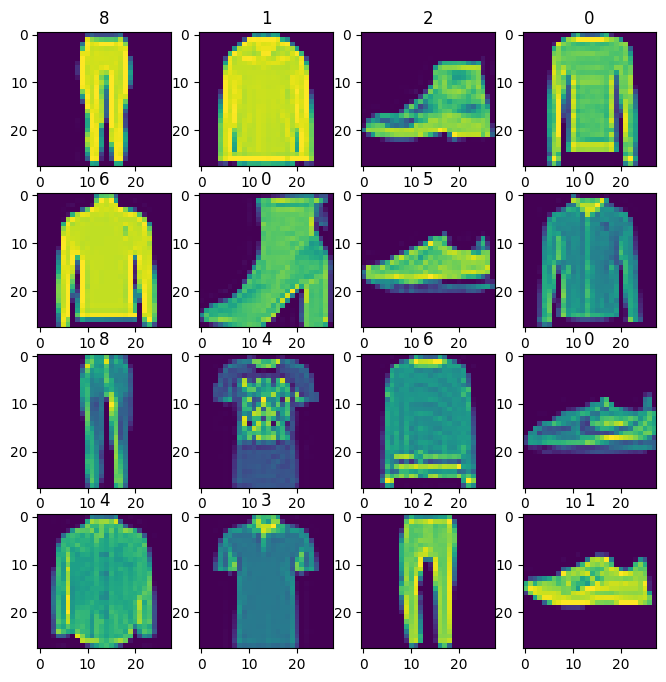

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(8,8))
index = 0
for x in range(4):
  for y in range(4):
    ax[x,y].imshow(dataiterator.next()['image'])
    ax[x,y].title.set_text(dataiterator.next()['label'])

In [9]:
def scale_image(data):
  image = data['image']
  return image/255

In [10]:
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [19]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, 4, activation='sigmoid', padding='same'))

  return model

In [20]:
testModel = build_generator()

In [21]:
testModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      